In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib as mpl

In [5]:
def displayImageInActualSize(I):
    dpi = mpl.rcParams['figure.dpi']
    H,W = I.shape
    fig_size = W/float(dpi), H/float(dpi)
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_axes([0,0,1,1])
    ax.axis('off')
    ax.imshow(I,cmap='gray')
    plt.show

def bilinearInterpolation(r, c, I):
   
    # Column indexes
    lc = int(c) # left column
    rc = lc+1   # right column

    # Row indexes
    tr = int(r) # top row
    br = tr + 1 # bottom row

    # Weights of horizontal linear indexes
    wr = c - lc
    wl = rc - c

    # Weights of vertical linear indexes
    wt = br - r
    wb = r - tr

    if tr >= 0 and br < I.shape[0] and lc >= 0 and rc < I.shape[1]:  
        # Intensity alpha (top row linear)
        a = I[tr, lc] * wl + I[tr, rc] * wr
        # Intensity betha (bottom row linear)
        b = I[br, lc] * wl + I[br, rc] * wr

        # Final intensity (vertical linear)
        f = a * wt + b * wb

        return np.uint8(f)
    else:
        return 0

In [6]:
def getExtentsAffine(T, rMax, cMax):
    cords = np.array([[0,0,1], [0, cMax-1, 1], [rMax, 0, 1], [rMax, cMax, 1]])
    A_dash = T.dot(cords.T)

    mins = A_dash.min(axis=1)
    maxs = A_dash.max(axis=1)

    minR = np.int64(np.floor(mins[0]))
    minC = np.int64(np.floor(mins[1]))
    maxR = np.int64(np.ceil(maxs[0]))
    maxC = np.int64(np.ceil(maxs[1]))

    # Define height and width
    H, W = maxR - minR + 1, maxC - minC + 1
    
    return minR, minC, maxR, maxC, H, W

def transformAffine(T, I_gray):
    Tinv = np.linalg.inv(T)

    numRows = I_gray.shape[0]
    numCols = I_gray.shape[1]

    minR, minC, maxR, maxC, H, W = getExtentsAffine(T, I_gray.shape[0], I_gray.shape[1])

    I2 = np.zeros((H,W), dtype='uint8')

    for new_i in range(minR, maxR):
        for new_j in range(minC, maxC):
            P_dash = np.array([new_i,new_j, 1])
            P = Tinv.dot(P_dash)
            # Bilinear interpolation
            P = np.int16(np.round(P))
            i, j = P[0], P[1]
            if i < 0 or i >= numRows or j < 0 or j >= numCols:
                pass
            else:
                g = bilinearInterpolation(i,j,I_gray)
                I2[new_i - minR, new_j - minC] = g
    return I2


In [7]:
grayPath = r'D:\Cursos Online\Computer_Vision_in_python\practice\Unit 4\albert-einstein_gray.jpg'

I_gray = cv2.imread(grayPath, cv2.IMREAD_GRAYSCALE)

In [11]:
# Rotation Matrix
a = 30  # Angle in degrees
ca = np.cos(np.deg2rad(a))
sa = np.sin(np.deg2rad(a))

# Rotation matrix
R = np.array([[ca, -sa, 0], [sa, ca, 0], [0, 0, 1]])

# Translation Matrix
T = np.array([[1, 0, -300], [0, 1, -400], [0, 0, 1]])

# Shear
Sh = np.array([[1, 0.5, 0], [0, 1, 0], [0, 0, 1]])

# Scale 
S = np.array([[1.3, 0, 0], [0, 0.7, 0], [0, 0, 1]])

# Total transformation
A = np.linalg.inv(T).dot(S).dot(R).dot(Sh).dot(T)
A

array([[  1.12583302,  -0.08708349,  -2.91651246],
       [  0.35      ,   0.78121778, -17.48711306],
       [  0.        ,   0.        ,   1.        ]])

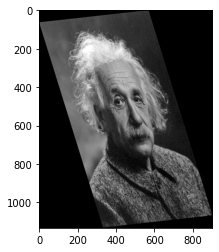

In [12]:
I2 = transformAffine(A, I_gray)
plt.imshow(I2, cmap='gray')